In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torchesn.nn import ESN

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Data Generation

In [3]:
def correlated_samples(nchs, n, cls=0, num_noise_chs=3, i=1):
    # The desired mean values of the sample.
    mu = np.array([5.0, 
                    0.0, 
                    10.0])
    
    y_noise = np.random.random((num_noise_chs, n))

    # The desired covariance matrix.
    if cls == 0:
        r = np.array([
            [  3, -2.75*i, -2.00*i],
            [ -2.75*i,  5,  1.50*i],
            [ -2.00*i,  1.50*i,  1]
        ])
    elif cls == 1:
        r = np.array([
            [  3, 0, 0],
            [ 0,  5, 0],
            [ 0,  0,  1.5]
        ])
    
    # Generate the random samples.
    y = np.random.multivariate_normal(mu, r, size=n).T
    
    y = np.vstack((y[0,:], y_noise[0,:], y[1,:], 
                        y_noise[1,:], y[2,:], y_noise[2,:]))
    
    return y

<IPython.core.display.Javascript object>

In [4]:
def simulate_data(cov_factor):
    np.random.seed(1234)

    # length of data sequence
    ns = np.array([50,100,200,
                   400,1000,2000
                  ])
    test_size = 0.5

    # simulated data parameters
    T = 100
    nchs = 6

    # initialize data structures for train/test data
    X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

    # simulate over varying sizes of data sequence
    for n in ns:
        y = []
        X = []

        # generate correlated multi-variate time series
        for i in range(n):
            _x = correlated_samples(nchs, T, cls=0, i=cov_factor)
            X.append(_x)
            y.append(0)
        for i in range(n):
            _x = correlated_samples(nchs, T, cls=1, i=cov_factor)
            X.append(_x)
            y.append(1)
        X = np.array(X)
        y = np.array(y)

        # perform training test split
        _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                            test_size=test_size, 
                                                            random_state=42)
        X_train = np.vstack((X_train, _X_train))
        Y_train = np.hstack((Y_train, _y_train))
        X_test = np.vstack((X_test, _X_test))
        Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, Y_train, X_test, Y_test

<IPython.core.display.Javascript object>

In [5]:
np.random.seed(1234)

# length of data sequence
ns = np.array([50,100,200,
               400,1000,2000
              ])
test_size = 0.5

# simulated data parameters
T = 1000
nchs = 6

# initialize data structures for train/test data
X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

# simulate over varying sizes of data sequence
for n in ns:
    y = []
    X = []
    
    # generate correlated multi-variate time series
    for i in range(n):
        _x = correlated_samples(nchs, T, cls=0)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = correlated_samples(nchs, T, cls=1)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)
    
    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=42)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

# Reshape for DeepESN
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

<ipython-input-3-a958c145d674>:24: RuntimeWarning: covariance is not positive-semidefinite.
  y = np.random.multivariate_normal(mu, r, size=n).T


<IPython.core.display.Javascript object>

# Deep Echo State Network (DeepESN)
Nice PyTorch implementation of DeepESN here: https://github.com/stefanonardo/pytorch-esn

Echo State Networks (ESNs) are a type of recurrent neural network (RNN) with a sparsely connected hidden layer (1% connectivity) that follow the deep learning paradigm of Reservoir Computing. Under the Reservoir Computing framework, an input signal gets fed into fixed (random) dynamical system called a “reservoir” and the dynamics of the reservoir map the input into higher dimensional space. A simple "readout" mechanism (e.g. Cholesky) is trained to read the state of the reservoir and map it to the desired output. The main benefits of this framework is that training is performed only at the readout stage and the reservoir is fixed, reducing relative computational efficiency.

The reservoir typically consists of recurrently connected units, where the connections are usually set at random and the units themselves typically are nonlinear. The readout mechanism is usually a linear transformation of the reservoir output, typically adapted to the task of interest using linear regression or ridge regression using a teaching signal.

In recent years, many variants on ESNs and other architectures have been developed, including TreeESN for tree-structured data; DeepESN, which utilizes consecutively stacked reservoirs; and Liquid-State Networks. TreeESN, DeepESN, and Deep TreeESN had all shown promise in (re)producing and discriminating structured time series data.

Some papers on DeepESN:

[1] <a href="https://arxiv.org/abs/1712.04323">Deep Echo State Network (DeepESN): A Brief Survey</a> by Claudio Gallicchio, Alessio Micheli

[2] <a href="">An effective multivariate time series classification approach using echo state network and adaptive differential evolution algorithm</a> by Lin Wang, Zhigang Wang, Shan Liu

In [16]:
batch_size = 32
input_size = 1
hidden_size = 500
output_size = 1
washout_rate = 0.2  # Value between 0 and 1, controls how leaky connections are between reservoirs

<IPython.core.display.Javascript object>

In [17]:
def accuracy_correct(y_pred, y_true):
    sigmoid = nn.Sigmoid()
    labels = sigmoid(y_pred) > 0.5
    correct = (labels.int() == y_true.int()).sum()
    return correct

<IPython.core.display.Javascript object>

In [18]:
def reshape_batch(x):
    x = x.transpose(0, 1)
    x = x.reshape(*x.shape, 1)
    return x

<IPython.core.display.Javascript object>

In [19]:
from torchesn.nn.echo_state_network import ESN

torch.manual_seed(1234)

all_n_train_obs = []
all_n_test_obs = []
all_train_errs = []
all_test_errs = []

for n in ns:
    Xtrain = torch.FloatTensor(X_train[:n])
    Ytrain = torch.FloatTensor(Y_train[:n])
    
    Xtest = torch.FloatTensor(X_test[:n])
    Ytest = torch.FloatTensor(Y_test[:n])
    
    train = torch.utils.data.TensorDataset(Xtrain, Ytrain)
    test = torch.utils.data.TensorDataset(Xtest, Ytest)

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False,num_workers=2)
    
    model = ESN(input_size, hidden_size, output_size, num_layers=1, output_steps='mean', readout_training='cholesky')
    
    # Training
    tot_correct = 0
    tot_obs = 0
    
    n_train_obs = []
    mean_train_errs = []
    
    trainStartTime = time.time()

    # Fitting model and building reservoirs
    for batch in train_loader:
        x, y = batch
        
        x = reshape_batch(x) 
        washout_list = [int(washout_rate * x.size(0))] * x.size(1)
        
        model(x, washout_list, None, y)
        model.fit()
        
    # Training on reservoir output (readout)
    for batch in train_loader:
        x, y = batch
        
        x = reshape_batch(x)
        washout_list = [int(washout_rate * x.size(0))] * x.size(1)

        output, hidden = model(x, washout_list)

        tot_obs += x.size(1)
        tot_correct += int(accuracy_correct(output[-1], y.type(torch.get_default_dtype())))
        
        acc = tot_correct / tot_obs
        
        n_train_obs.append(tot_obs)
        mean_train_errs.append(acc)
    
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime
    
    all_n_train_obs.append(n_train_obs)
    all_train_errs.append(mean_train_errs)
    
    acc = tot_correct / tot_obs
    err = 1 - acc
    print(f"n={n}\tTrain Time: {trainTime:2.6f}\tMean Training error: {1 - acc:.6f}")

    
    # Testing
    tot_obs = 0
    tot_correct = 0

    n_test_obs = []
    mean_test_errs = []
    
    testStartTime = time.time()
    for batch in test_loader:
        x, y = batch
        
        x = reshape_batch(x) 
        washout_list = [int(washout_rate * x.size(0))] * x.size(1)

        output, hidden = model(x, washout_list)

        tot_correct += int(accuracy_correct(output[-1], y.type(torch.get_default_dtype())))
        tot_obs += x.size(1)
        
        acc = tot_correct / tot_obs
        
        n_test_obs.append(tot_obs)
        mean_test_errs.append(acc)

    testEndTime = time.time()
    testTime = testEndTime - testStartTime
    
    all_n_test_obs.append(n_test_obs)
    all_test_errs.append(mean_test_errs)
    
    acc = tot_correct / tot_obs
    print(f"n={n}\tTest Time: {testTime:2.6f}\tMean Testing error: {1 - acc:.6f}\n")

n=50	Train Time: 23.248545	Mean Training error: 0.460000
n=50	Test Time: 11.490611	Mean Testing error: 0.540000

n=100	Train Time: 47.321570	Mean Training error: 0.410000
n=100	Test Time: 25.476818	Mean Testing error: 0.560000

n=200	Train Time: 95.599617	Mean Training error: 0.535000
n=200	Test Time: 50.446738	Mean Testing error: 0.490000

n=400	Train Time: 169.359695	Mean Training error: 0.527500
n=400	Test Time: 81.994756	Mean Testing error: 0.482500

n=1000	Train Time: 416.448171	Mean Training error: 0.492000
n=1000	Test Time: 203.669903	Mean Testing error: 0.521000

n=2000	Train Time: 796.218118	Mean Training error: 0.510000
n=2000	Test Time: 412.025543	Mean Testing error: 0.506000



<IPython.core.display.Javascript object>

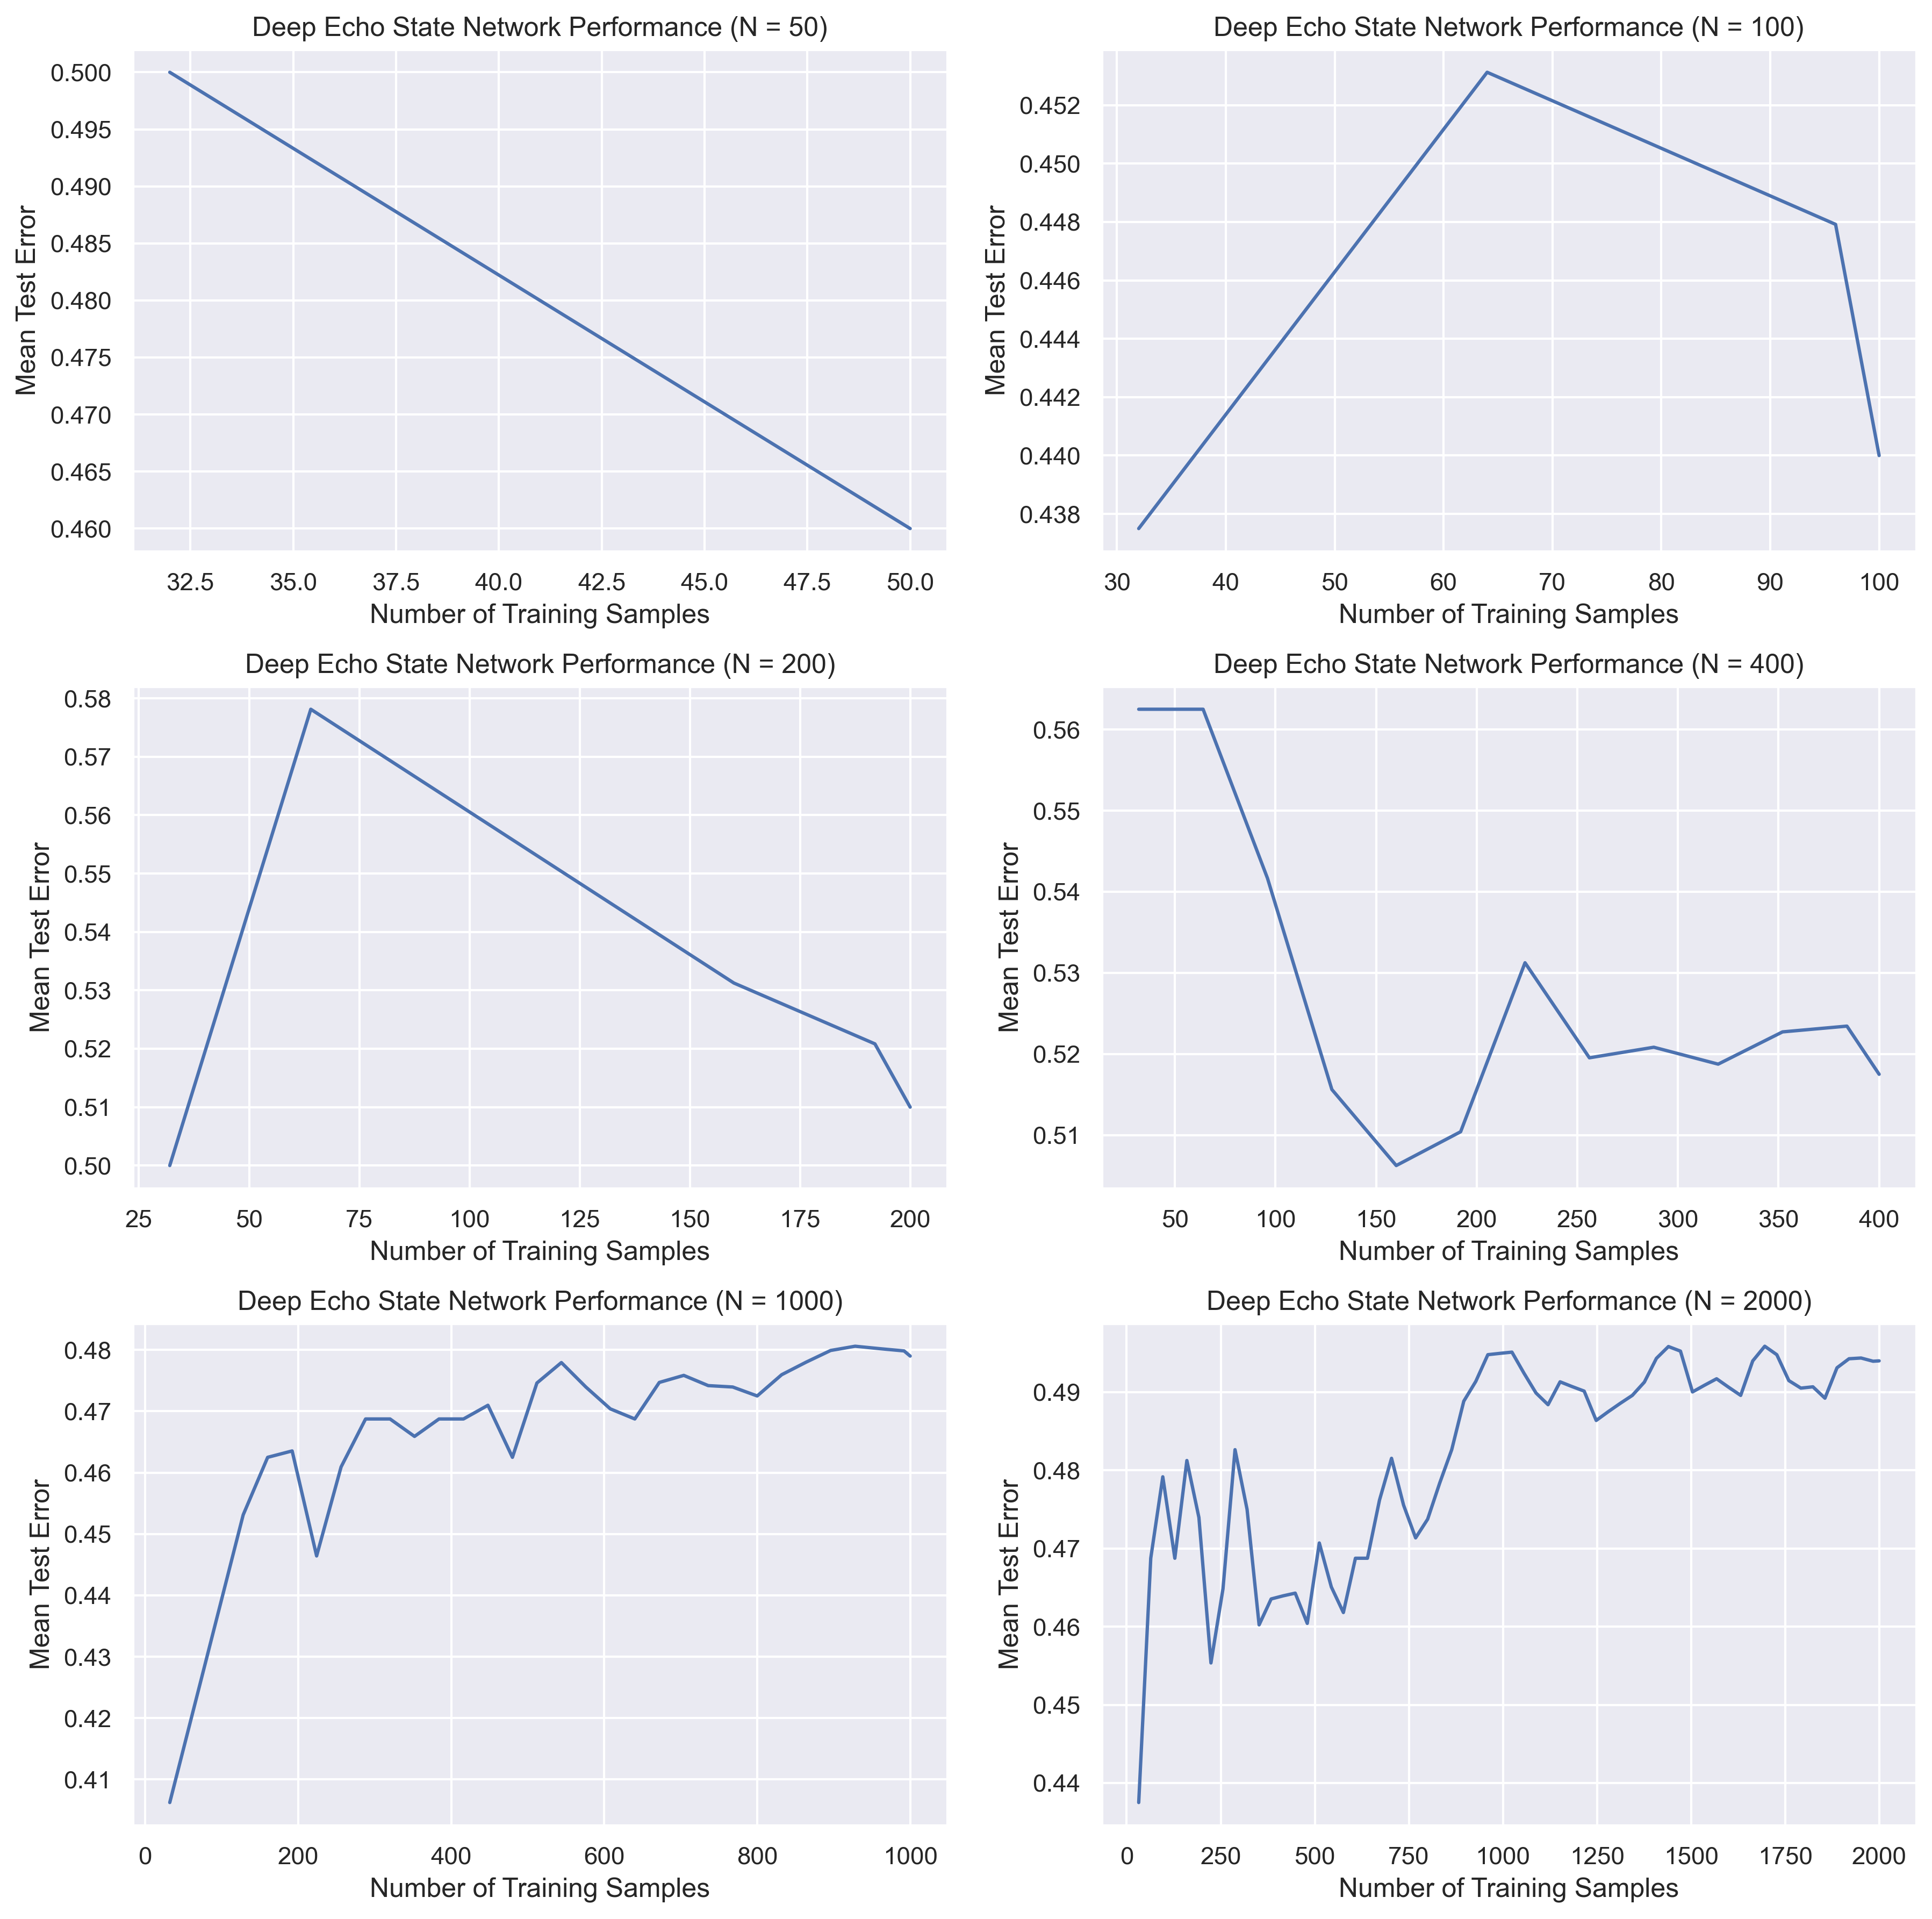

<IPython.core.display.Javascript object>

In [20]:
fig, axs = plt.subplots(int(np.ceil(len(ns) / 2)), 2, dpi=300, figsize=(12, 12))
axs = axs.flatten()

for i, n in enumerate(ns):
    sns.lineplot(all_n_test_obs[i], all_test_errs[i], ax=axs[i])
    axs[i].set(
        title=f"Deep Echo State Network Performance (N = {n})",
        xlabel=f"Number of Training Samples",
        ylabel=f"Mean Test Error"
    );
fig.tight_layout()